In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
from collections import Counter

input_file_segments = '/content/drive/MyDrive/Project/ExtractedSegments_1s_set2.npy'
input_file_labels = '/content/drive/MyDrive/Project/ExtractedLabelas_1s_set2.npy'

loaded_segments = np.load(input_file_segments, allow_pickle=True)
loaded_labels = np.load(input_file_labels, allow_pickle=True)

print(f'Total segments loaded: {len(loaded_segments)}')
print(f'Total labels loaded: {len(loaded_labels)}')
print(f'Sample segment shape: {loaded_segments[0].shape}')
print(f'Sample label: {loaded_labels[0]}')

label_counts = Counter(loaded_labels)
print(f'Label counts: {label_counts}')

max_count = max(label_counts.values())

def add_gaussian_noise(data, mean=0, std_dev=0.05):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

augmented_segments = []
augmented_labels = []

for segment, label in zip(loaded_segments, loaded_labels):
    if segment.shape == (125, 16):
        augmented_segments.append(segment)
        augmented_labels.append(label)
    else:
        print(f"Skipping segment with invalid shape: {segment.shape}")

for label, count in label_counts.items():
    if count < max_count:

        label_segments = [seg for seg, lbl in zip(loaded_segments, loaded_labels) if lbl == label]


        num_samples_needed = max_count - count

        for _ in range(num_samples_needed):

            segment = label_segments[np.random.randint(len(label_segments))]
            noisy_segment = add_gaussian_noise(segment)


            if noisy_segment.shape == (125, 16):
                augmented_segments.append(noisy_segment)
                augmented_labels.append(label)
            else:
                print(f"Generated segment with invalid shape: {noisy_segment.shape}")

augmented_segments = np.array(augmented_segments)
augmented_labels = np.array(augmented_labels)

print(f'Augmented data shape: {augmented_segments.shape}')
print(f'Augmented labels shape: {augmented_labels.shape}')
print(f'New label counts: {Counter(augmented_labels)}')

Total segments loaded: 935
Total labels loaded: 935
Sample segment shape: (125, 16)
Sample label: Walking
Label counts: Counter({'Walking': 290, 'Aha': 290, 'Doing Other Task': 289, 'Impasse': 41, 'Re-evaluation': 25})
Skipping segment with invalid shape: (146, 16)
Skipping segment with invalid shape: (183, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Augmented data shape: (1438, 125, 16)
Augmented labels shape: (1438,)
New label counts: Counter({'Walking': 290, 'Aha': 290, 'Re-evaluation': 290, 'Doing Other Task': 289, 'Impasse': 279})


In [16]:
data = augmented_segments
final_labels = augmented_labels

In [17]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pandas as pd

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(final_labels)

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(data, encoded_labels):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = encoded_labels[train_index], encoded_labels[test_index]

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

def build_e2fnet(input_shape=(125, 16, 1), num_classes=5):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding="same", strides=(1, 1))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)

    temporal_features = Reshape((125, -1))(inputs)
    temporal_features = LSTM(64, return_sequences=True)(temporal_features)
    temporal_features = LSTM(64)(temporal_features)

    fused = concatenate([x, temporal_features])
    fused = Dropout(0.5)(fused)

    output = Dense(num_classes, activation="softmax")(fused)

    model = Model(inputs=inputs, outputs=output)
    return model




main_model = build_e2fnet(input_shape=(125, 16, 1), num_classes=5)
main_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

main_model.summary()


history = main_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

test_loss, test_accuracy = main_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

test_loss_train, test_accuracy_train = main_model.evaluate(X_train, y_train)
print(f'Train Accuracy: {test_accuracy_train:.4f}')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 125, 16, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 125, 16, 32)    │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 125, 16, 32)    │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 125, 16, 32)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 62, 8, 32)      │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 62, 8, 64)      │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 62, 8, 64)      │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 62, 8, 64)      │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 31, 4, 64)      │              0 │ re_lu_4[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 31, 4, 128)     │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 31, 4, 128)     │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 125, 16)        │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 31, 4, 128)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 125, 64)        │         20,736 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ re_lu_5[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 64)             │         33,024 │ lstm_2[0][0]           │
├──────────────────────

 Total params: 148,293 (579.27 KB)

 Trainable params: 147,845 (577.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.2187 - loss: 1.7381 - val_accuracy: 0.4007 - val_loss: 1.7937
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.4061 - loss: 1.4895 - val_accuracy: 0.5331 - val_loss: 1.3400
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.5346 - loss: 1.2710 - val_accuracy: 0.6411 - val_loss: 1.0124
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.5886 - loss: 0.9944 - val_accuracy: 0.6551 - val_loss: 0.9853
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.6611 - loss: 0.8387 - val_accuracy: 0.6760 - val_loss: 0.8340
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.6981 - loss: 0.7513 - val_accuracy: 0.6934 - val_loss: 0.7773
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - accuracy: 0.7308 - loss: 0.7013 - val_accuracy: 0.7352 - val_loss: 0.7220
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.7550 - loss: 0.6528 - val_accu

In [18]:
X_train.shape

(1151, 125, 16)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step


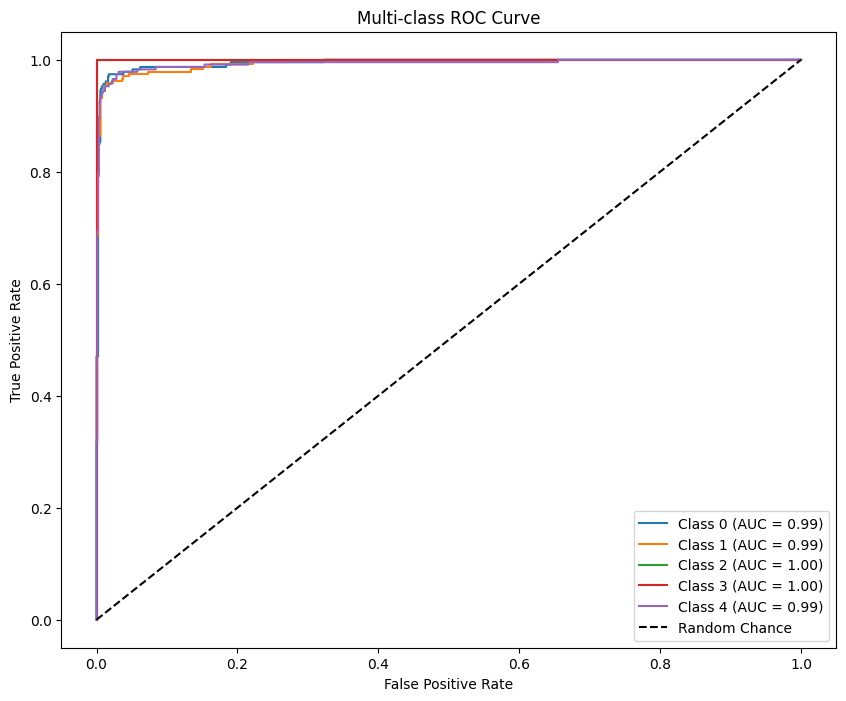

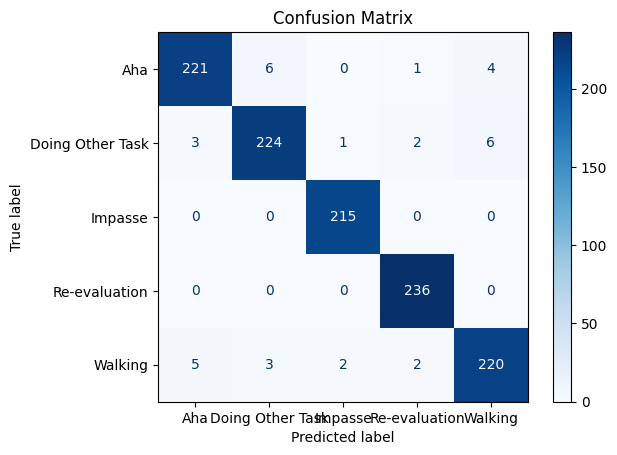

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


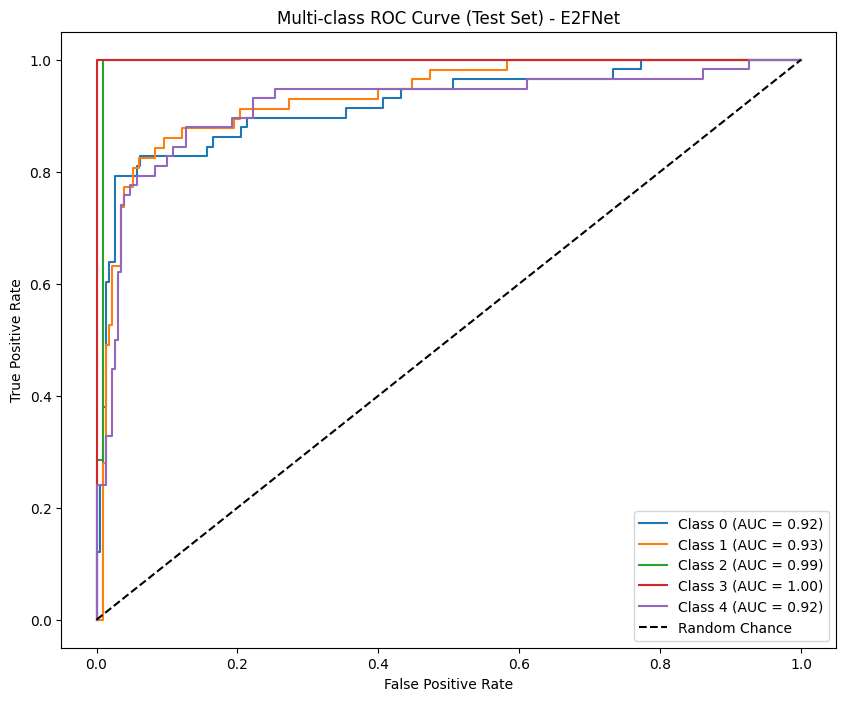

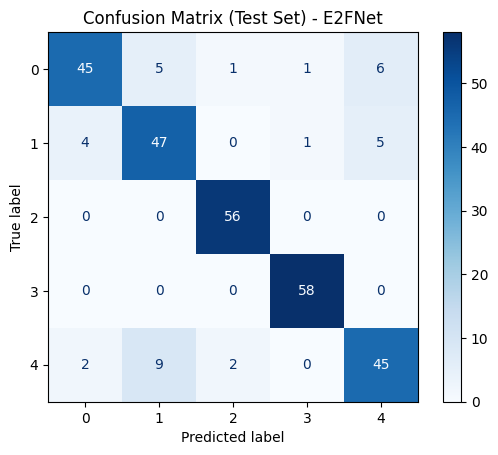

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

y_train_binary = to_categorical(y_train, num_classes=5)
y_test_binary = to_categorical(y_test, num_classes=5)

y_pred_probs = main_model.predict(X_train)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_train_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='best')
plt.show()

conf_matrix = confusion_matrix(y_train, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


y_test_pred_probs = main_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

fpr_test = {}
tpr_test = {}
roc_auc_test = {}
for i in range(5):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_binary[:, i], y_test_pred_probs[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr_test[i], tpr_test[i], label=f'Class {i} (AUC = {roc_auc_test[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Test Set) - E2FNet')
plt.legend(loc='best')
plt.show()

conf_matrix_test = confusion_matrix(np.argmax(y_test_binary, axis=1), y_test_pred_classes)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=np.arange(5))
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set) - E2FNet")
plt.show()

Train Accuracy: 0.970, Test Accuracy: 0.875


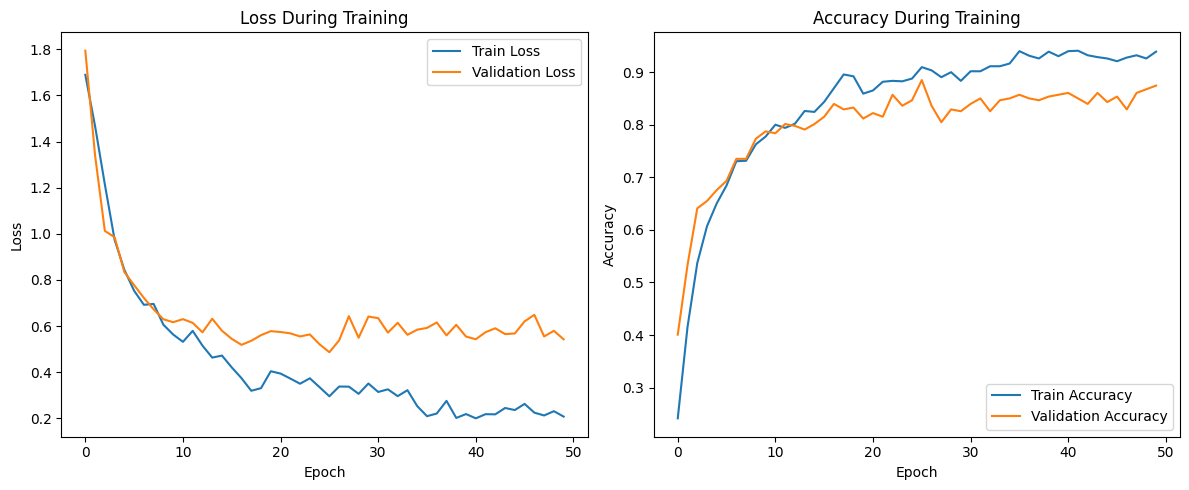

In [20]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

_, train_acc = main_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = main_model.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report

y_train_pred_classes = np.argmax(main_model.predict(X_train), axis=1)
y_test_pred_classes = np.argmax(main_model.predict(X_test), axis=1)

y_train_true_classes = np.argmax(y_train_one_hot, axis=1)
y_test_true_classes = np.argmax(y_test_one_hot, axis=1)

print("Training Set Metrics:")
train_report = classification_report(
    y_train_true_classes, y_train_pred_classes, target_names=[f"Class {i}" for i in range(5)]
)
print(train_report)

print("Test Set Metrics:")
test_report = classification_report(
    y_test_true_classes, y_test_pred_classes, target_names=[f"Class {i}" for i in range(5)]
)
print(test_report)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Training Set Metrics:
              precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96       232
     Class 1       0.96      0.95      0.96       236
     Class 2       0.99      1.00      0.99       215
     Class 3       0.98      1.00      0.99       236
     Class 4       0.96      0.95      0.95       232

    accuracy                           0.97      1151
   macro avg       0.97      0.97      0.97      1151
weighted avg       0.97      0.97      0.97      1151

Test Set Metrics:
              precision    recall  f1-score   support

     Class 0       0.88      0.78      0.83        58
     Class 1       0.77      0.82      0.80        57
     Class 2       0.95      1.00      0.97        56
     Class 3       0.97      1.00      0.98        58
     Class 4       0.80      0.78      0.79        58

    accuracy                           0.87       287
   macro avg 

In [23]:
spatial_model = Model(inputs=main_model.input, outputs=main_model.get_layer('global_average_pooling2d_1').output)
temporal_model = Model(inputs=main_model.input, outputs=main_model.get_layer('lstm_3').output)

X_train_spatial = spatial_model.predict(X_train)
X_train_temporal = temporal_model.predict(X_train)
X_test_spatial = spatial_model.predict(X_test)
X_test_temporal = temporal_model.predict(X_test)

X_train_features = np.concatenate([X_train_spatial, X_train_temporal], axis=1)
X_test_features = np.concatenate([X_test_spatial, X_test_temporal], axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

classifiers = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "K-Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB()
}

results = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train_features, y_train)

    y_pred_train = clf.predict(X_train_features)
    y_pred_test = clf.predict(X_test_features)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    print(f"\nClassifier: {clf_name}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("Classification Report (Test Data):")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

    results[clf_name] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1
    }

results_df = pd.DataFrame(results).T
print("\nSummary of Classifier Performance:")
print(results_df)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Classifier: SVM
Train Accuracy: 0.9818
Test Accuracy: 0.8850
Test Precision: 0.8849
Test Recall: 0.8850
Test F1 Score: 0.8842
Classification Report (Test Data):
                  precision    recall  f1-score   support

             Aha       0.87      0.78      0.82        58
Doing Other Task       0.79      0.84      0.81        57
         Impasse       0.97      1.00      0.98        56
   Re-evaluation       0.98      1.00      0.99        58
         Walking       0.82      0.81      0.82        58

        accuracy                           0.89       287
       macro avg       0.89      0.89      0.88       287
    weighted avg       0.88      0.89      0.88       287


Classifier: Random Forest
Train Accuracy: 0.9991
Test Accuracy: 0.8955
Test Precision: 0.8961
Test Recall: 0.8955
Test F1 Score: 0.8950
Classification Repor

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-


Classifier: AdaBoost
Train Accuracy: 0.3927
Test Accuracy: 0.3937
Test Precision: 0.2378
Test Recall: 0.3937
Test F1 Score: 0.2709
Classification Report (Test Data):
                  precision    recall  f1-score   support

             Aha       0.00      0.00      0.00        58
Doing Other Task       0.25      1.00      0.40        57
         Impasse       0.97      1.00      0.98        56
   Re-evaluation       0.00      0.00      0.00        58
         Walking       0.00      0.00      0.00        58

        accuracy                           0.39       287
       macro avg       0.24      0.40      0.28       287
    weighted avg       0.24      0.39      0.27       287


Classifier: XGBoost
Train Accuracy: 0.9991
Test Accuracy: 0.8955
Test Precision: 0.8960
Test Recall: 0.8955
Test F1 Score: 0.8950
Classification Report (Test Data):
                  precision    recall  f1-score   support

             Aha       0.88      0.79      0.84        58
Doing Other Task       0.